In [182]:
!pip install pyheif

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [183]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [184]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow
%cd ..

fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5
/content


In [185]:
%matplotlib inline

In [186]:
import pandas as pd
import os
from PIL import Image, ImageDraw
import numpy as np
import pyheif 
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json
import shutil

In [187]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!cp /content/drive/MyDrive/AI/hacks-ai/ulyanovsk/train_dataset_train.zip /content/train_dataset_train.zip 

In [9]:
!cp /content/drive/MyDrive/AI/hacks-ai/ulyanovsk/test_dataset_test.zip /content/test_dataset_test.zip

In [8]:
!cp /content/drive/MyDrive/AI/hacks-ai/ulyanovsk/label.zip /content/label.zip

## autoria 

In [ ]:
os.listdir('/content/drive/MyDrive/AI/hacks-ai/ulyanovsk/')

['train_dataset_train.zip', 'test_dataset_test.zip', 'best.pt']

In [ ]:
!wget https://nomeroff.net.ua/datasets/autoriaNumberplateDataset-2020-12-17.zip

--2022-08-06 14:51:32--  https://nomeroff.net.ua/datasets/autoriaNumberplateDataset-2020-12-17.zip
Resolving nomeroff.net.ua (nomeroff.net.ua)... 31.28.161.85
Connecting to nomeroff.net.ua (nomeroff.net.ua)|31.28.161.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1169522765 (1.1G) [application/zip]
Saving to: ‘autoriaNumberplateDataset-2020-12-17.zip’

autoriaNumberplateD 100%[===================>]   1.09G  17.4MB/s    in 66s     

2022-08-06 14:52:39 (17.0 MB/s) - ‘autoriaNumberplateDataset-2020-12-17.zip’ saved [1169522765/1169522765]



In [ ]:
!unzip autoriaNumberplateDataset-2020-12-17.zip

Archive:  autoriaNumberplateDataset-2020-12-17.zip
   creating: autoriaNumberplateDataset-2020-12-17/
   creating: autoriaNumberplateDataset-2020-12-17/val/
  inflating: autoriaNumberplateDataset-2020-12-17/val/10700181-Image-1.jpeg  
  inflating: autoriaNumberplateDataset-2020-12-17/val/10774620-photo_2018-08-21_20-21-46.jpg  
  inflating: autoriaNumberplateDataset-2020-12-17/val/10797070-Image-1.jpeg  
  inflating: autoriaNumberplateDataset-2020-12-17/val/10809067-IMG_0310.JPG  
  inflating: autoriaNumberplateDataset-2020-12-17/val/10853316-20190307_163552.jpg  
  inflating: autoriaNumberplateDataset-2020-12-17/val/111936627orig.jpeg  
  inflating: autoriaNumberplateDataset-2020-12-17/val/115086916orig.jpeg  
  inflating: autoriaNumberplateDataset-2020-12-17/val/124228322orig.jpeg  
  inflating: autoriaNumberplateDataset-2020-12-17/val/144784391orig.jpeg  
  inflating: autoriaNumberplateDataset-2020-12-17/val/145288247orig.jpeg  
  inflating: autoriaNumberplateDataset-2020-12-17/val/

In [ ]:
!wget https://lodmedia.hb.bizmrg.com/case_files/791333/train_dataset_train.zip

--2022-08-03 05:50:34--  https://lodmedia.hb.bizmrg.com/case_files/791333/train_dataset_train.zip
Resolving lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)... 217.69.142.100
Connecting to lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)|217.69.142.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2038686560 (1.9G) [application/zip]
Saving to: ‘train_dataset_train.zip’

train_dataset_train 100%[===================>]   1.90G  25.1MB/s    in 84s     

2022-08-03 05:51:58 (23.3 MB/s) - ‘train_dataset_train.zip’ saved [2038686560/2038686560]



In [ ]:
!wget https://lodmedia.hb.bizmrg.com/case_files/791333/test_dataset_test.zip

--2022-08-07 07:12:10--  https://lodmedia.hb.bizmrg.com/case_files/791333/test_dataset_test.zip
Resolving lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)... 217.69.142.100
Connecting to lodmedia.hb.bizmrg.com (lodmedia.hb.bizmrg.com)|217.69.142.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2031382717 (1.9G) [application/zip]
Saving to: ‘test_dataset_test.zip’

test_dataset_test.z 100%[===================>]   1.89G   746KB/s    in 59m 7s  

2022-08-07 08:11:18 (559 KB/s) - ‘test_dataset_test.zip’ saved [2031382717/2031382717]



In [ ]:
train_path = '/content/autoriaNumberplateDataset-2020-12-17/train/'

In [ ]:
val_path = '/content/autoriaNumberplateDataset-2020-12-17/val/'

In [ ]:
with open(train_path + 'via_region_data.json', 'r') as read_file:
    train_data = json.load(read_file)

In [ ]:
with open(val_path + 'via_region_data.json', 'r') as read_file:
    val_data = json.load(read_file)

In [ ]:
def get_object_params(width, height, x_min, y_min, x_max, y_max):
  image_width = 1.0 * width
  image_height = 1.0 * height

  absolute_x = x_min + 0.5 * (x_max - x_min)
  absolute_y = y_min + 0.5 * (y_max - y_min)

  absolute_width = x_max - x_min
  absolute_height = y_max - y_min

  x = absolute_x / image_width
  y = absolute_y / image_height
  width = absolute_width / image_width
  height = absolute_height / image_height

  return abs(round(x, 6)), abs(round(y, 6)), abs(round(width, 6)), abs(round(height, 6))

In [ ]:
def extract_regions(path, img_data):
  filename = img_data['filename']

  if 'heic' in filename:
    heif_file = pyheif.read(os.path.join(path, filename))
    img = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw", heif_file.mode, heif_file.stride)
  else:
    img = Image.open(os.path.join(path, filename))

  w, h = img.size

  result = ''
  for region in img_data['regions']:
    region_str = '0 '
    x_min = region['shape_attributes']['all_points_x'][0]
    y_min = region['shape_attributes']['all_points_y'][0]
    x_max = region['shape_attributes']['all_points_x'][2]
    y_max = region['shape_attributes']['all_points_y'][2]
    x, y, width, height = get_object_params(w, h, x_min, y_min, x_max, y_max)
    region_str += str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + '\n'
    result += region_str

  with open('/content/prepare/annotations/' + filename.replace('.png', '').replace('.jpg', '').replace('.jpeg', '') + '.txt', 'w') as write_file:
    write_file.write(result)


In [ ]:
extract_regions(train_path, train_data['_via_img_metadata']['08700034-43757278.jpg41438'])

'0 0.253846 0.696825 0.073077 0.073016\n0 0.780769 0.790476 0.107692 0.044444\n'

In [ ]:
!rm -r /content/prepare/annotations

In [ ]:
!mkdir /content/prepare

In [ ]:
!mkdir /content/prepare/images /content/prepare/annotations

In [ ]:
!mkdir /content/images /content/annotations

In [ ]:
for key in train_data['_via_img_metadata'].keys():
  extract_regions(train_path, train_data['_via_img_metadata'][key])

In [ ]:
for key in val_data['_via_img_metadata'].keys():
  extract_regions(val_path, val_data['_via_img_metadata'][key])

In [ ]:
for x in os.listdir(train_path):
  shutil.move(os.path.join(train_path, x), '/content/prepare/images')

In [ ]:
!rm  /content/prepare/images/via_region_data.json

In [ ]:
for x in os.listdir(val_path):
  shutil.move(os.path.join(val_path, x), '/content/prepare/images')

In [ ]:
!rm  /content/prepare/images/via_region_data.json

In [ ]:
images = [os.path.join('/content/prepare/images', x) for x in os.listdir('/content/prepare/images')]
annotations = [os.path.join('/content/prepare/annotations', x) for x in os.listdir('/content/prepare/annotations')]

In [ ]:

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 45)

In [ ]:
!cp /content/drive/MyDrive/AI/hacks-ai/ufa/garbage_data.yaml /content/yolov5/data/licence_plate_data.yaml

In [ ]:
!mkdir /content/images/train /content/images/val /content/annotations/train /content/annotations/val

In [ ]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

# Move the splits into their folders
move_files_to_folder(train_images, '/content/images/train')
move_files_to_folder(val_images, '/content/images/val/')
#move_files_to_folder(test_images, 'images/test/')
move_files_to_folder(train_annotations, '/content/annotations/train/')
move_files_to_folder(val_annotations, '/content/annotations/val/')

In [ ]:
!mv /content/annotations /content/labels

In [ ]:
!python /content/yolov5/train.py --img 416 --cfg yolov5s.yaml --hyp hyp.scratch-low.yaml --batch 32 --epochs 300 --data licence_plate_data.yaml --weights yolov5s.pt --workers 2 --name yolo_licence_plate_det

train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=licence_plate_data.yaml, hyp=hyp.scratch-low.yaml, epochs=300, batch_size=32, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=yolov5/runs/train, name=yolo_licence_plate_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-373-g8f28ea4 Python-3.7.13 torch-1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4

## Train carplate

In [10]:
!unzip train_dataset_train.zip

Archive:  train_dataset_train.zip
   creating: train/
  inflating: train/img_1596.jpg      
  inflating: train/img_1600.jpg      
  inflating: train/img_1601.jpg      
  inflating: train/img_1603.jpg      
  inflating: train/img_1605.jpg      
  inflating: train/img_1606.jpg      
  inflating: train/img_1607.jpg      
  inflating: train/img_1608.jpg      
  inflating: train/img_1612.jpg      
  inflating: train/img_1613.jpg      
  inflating: train/img_1615.jpg      
  inflating: train/img_1616.jpg      
  inflating: train/img_1618.jpg      
  inflating: train/img_1619.jpg      
  inflating: train/img_1620.jpg      
  inflating: train/img_1621.jpg      
  inflating: train/img_1623.jpg      
  inflating: train/img_1626.jpg      
  inflating: train/img_1627.jpg      
  inflating: train/img_1628.jpg      
  inflating: train/img_1631.jpg      
  inflating: train/img_1634.jpg      
  inflating: train/img_1635.jpg      
  inflating: train/img_1637.jpg      
  inflating: train/img_1640.jpg   

In [11]:
!unzip test_dataset_test.zip

Archive:  test_dataset_test.zip
   creating: test/
  inflating: test/img_1597.jpg       
  inflating: test/img_1598.jpg       
  inflating: test/img_1599.jpg       
  inflating: test/img_1602.jpg       
  inflating: test/img_1604.jpg       
  inflating: test/img_1609.jpg       
  inflating: test/img_1610.jpg       
  inflating: test/img_1611.jpg       
  inflating: test/img_1617.jpg       
  inflating: test/img_1622.jpg       
  inflating: test/img_1625.jpg       
  inflating: test/img_1629.jpg       
  inflating: test/img_1630.jpg       
  inflating: test/img_1632.jpg       
  inflating: test/img_1633.jpg       
  inflating: test/img_1636.jpg       
  inflating: test/img_1638.jpg       
  inflating: test/img_1639.jpg       
  inflating: test/img_1642.jpg       
  inflating: test/img_1644.jpg       
  inflating: test/img_1646.jpg       
  inflating: test/img_1648.jpg       
  inflating: test/img_1651.jpg       
  inflating: test/img_1652.jpg       
  inflating: test/img_1654.jpg       

In [12]:
!unzip label

Archive:  label.zip
   creating: label/
  inflating: label/img_1596.txt      
  inflating: label/img_1600.txt      
  inflating: label/img_1601.txt      
  inflating: label/img_1603.txt      
  inflating: label/img_1605.txt      
  inflating: label/img_1606.txt      
  inflating: label/img_1607.txt      
  inflating: label/img_1608.txt      
  inflating: label/img_1612.txt      
  inflating: label/img_1613.txt      
  inflating: label/img_1615.txt      
  inflating: label/img_1616.txt      
  inflating: label/img_1618.txt      
  inflating: label/img_1619.txt      
  inflating: label/img_1620.txt      
  inflating: label/img_1621.txt      
  inflating: label/img_1623.txt      
  inflating: label/img_1626.txt      
  inflating: label/img_1627.txt      
  inflating: label/img_1628.txt      
  inflating: label/img_1631.txt      
  inflating: label/img_1634.txt      
  inflating: label/img_1635.txt      
  inflating: label/img_1637.txt      
  inflating: label/img_1640.txt      
  inflatin

In [378]:
!mv /content/label /content/labels

In [379]:
images = [x for x in os.listdir('/content/train')]
annotations = [x for x in os.listdir('/content/labels')]

In [380]:
!mkdir /content/prepare

In [381]:
!mkdir /content/images

In [382]:
!mkdir /content/images/train /content/images/val /content/labels/train /content/labels/val

In [383]:
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            assert False

In [384]:
len(images)

579

In [385]:
for img in images:
  if img.replace('.jpg', '').replace('.jpeg', '') + '.txt' in annotations:
    shutil.copy('/content/train/' + img, '/content/prepare/' + img)

In [386]:
len(os.listdir('/content/prepare/'))

481

In [387]:
images = [os.path.join('/content/prepare', x) for x in os.listdir('/content/prepare')]
annotations = [os.path.join('/content/labels', x) for x in os.listdir('/content/labels') if x[-3:] == "txt"]

In [388]:

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 45)

In [389]:
# Move the splits into their folders
move_files_to_folder(train_images, '/content/images/train')
move_files_to_folder(val_images, '/content/images/val/')
#move_files_to_folder(test_images, 'images/test/')



In [390]:
move_files_to_folder(train_annotations, '/content/labels/train/')
move_files_to_folder(val_annotations, '/content/labels/val/')

In [391]:
!cp /content/drive/MyDrive/AI/hacks-ai/ufa/garbage_data.yaml /content/yolov5/data/carplate_data.yaml

In [ ]:
#python train.py --img 1900 --epoch 100 --batch 2 --data custom.yaml --hyp hyp_evolve.yaml --weights yolov5x6.pt --name 1900 --cache disk 


In [395]:
!python /content/yolov5/train.py --img 480 --cfg yolov5m.yaml --hyp hyp.scratch-med.yaml --batch 16 --epochs 50--data carplate_data.yaml --weights /content/yolov5/runs/train/yolo_carplate_det/weights/last.pt --workers 2 --name yolo_carplate_det

train: weights=/content/yolov5/runs/train/yolo_carplate_det/weights/last.pt, cfg=yolov5m.yaml, data=carplate_data.yaml, hyp=hyp.scratch-med.yaml, epochs=2, batch_size=16, imgsz=480, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=yolov5/runs/train, name=yolo_carplate_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-56-g30e674b Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.3, cls_pw=1.0, obj=0.

In [ ]:
!python /content/yolov5/train.py --img 480 --cfg yolov5l.yaml --hyp hyp.scratch-med.yaml --batch 16 --epochs 50 --data carplate_data.yaml --weights yolov5l.pt --workers 2 --name yolo_licence_plate_det

train: weights=yolov5l.pt, cfg=yolov5l.yaml, data=carplate_data.yaml, hyp=hyp.scratch-med.yaml, epochs=50, batch_size=16, imgsz=800, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=2, project=yolov5/runs/train, name=yolo_licence_plate_det, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-46-g06831aa Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.3, cls_pw=1.0, obj=0.7, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_g

In [ ]:
!cp /content/test/img_1597.jpg /content/ttt/img_1597.jpg
!cp /content/test/img_1609.jpg /content/ttt/img_1609.jpg
!cp /content/test/img_1638.jpg /content/ttt/img_1638.jpg
!cp /content/test/img_1694.jpg /content/ttt/img_1694.jpg

In [397]:
!python /content/yolov5/detect.py --source /content/tmp/ --img 480 --save-txt --weights /content/drive/MyDrive/AI/hacks-ai/ulyanovsk/best.pt --conf 0.25 --name yolo_licence_plate_det

detect: weights=['/content/drive/MyDrive/AI/hacks-ai/ulyanovsk/best.pt'], source=/content/tmp/, data=yolov5/data/coco128.yaml, imgsz=[480, 480], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=yolo_licence_plate_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.2-56-g30e674b Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
image 1/1 /content/tmp/img_1629.jpg: 384x480 1 garbage, 12.7ms
Speed: 0.4ms pre-process, 12.7ms inference, 7.9ms NMS per image at shape (1, 3, 480, 480)
Results saved to yolov5/runs/detect/yolo_licence_plate_det10
1 labels saved to yolov5/runs/detect/yolo_licence_plate_det10/labels


In [ ]:
!cp /content/yolov5/runs/train/yolo_licence_plate_det3/weights/best.pt /content/drive/MyDrive/AI/hacks-ai/ulyanovsk/best2.pt

In [ ]:
label_path = '/content/yolov5/runs/detect/yolo_licence_plate_det3/labels/' #path of labels

In [ ]:
image_path = '/content/yolov5/runs/detect/yolo_licence_plate_det3/' #path of labels

In [ ]:
labels = os.listdir(label_path)

FileNotFoundError: ignored

## Functions

In [13]:
train_heif_images = [os.path.join('/content/train', x) for x in os.listdir('/content/train') if x[-4:] == "heic"]

In [14]:
train_heif_images

['/content/train/img_2749.heic',
 '/content/train/img_2729.heic',
 '/content/train/img_2699.heic',
 '/content/train/img_2727.heic',
 '/content/train/img_2676.heic',
 '/content/train/img_2733.heic',
 '/content/train/img_2747.heic',
 '/content/train/img_2675.heic',
 '/content/train/img_2710.heic',
 '/content/train/img_2700.heic',
 '/content/train/img_2730.heic',
 '/content/train/img_2695.heic',
 '/content/train/img_2734.heic',
 '/content/train/img_2683.heic',
 '/content/train/img_2682.heic',
 '/content/train/img_2744.heic',
 '/content/train/img_2721.heic',
 '/content/train/img_2737.heic',
 '/content/train/img_2740.heic',
 '/content/train/img_2705.heic',
 '/content/train/img_2701.heic',
 '/content/train/img_2735.heic',
 '/content/train/img_2743.heic',
 '/content/train/img_2691.heic',
 '/content/train/img_2673.heic',
 '/content/train/img_2746.heic',
 '/content/train/img_2681.heic',
 '/content/train/img_2738.heic',
 '/content/train/img_2678.heic',
 '/content/train/img_2690.heic',
 '/content

In [13]:
heif_images = [os.path.join('/content/test', x) for x in os.listdir('/content/test') if x[-4:] == "heic"]

In [14]:
heif_images

['/content/test/img_2719.heic',
 '/content/test/img_2693.heic',
 '/content/test/img_2717.heic',
 '/content/test/img_2712.heic',
 '/content/test/img_2725.heic',
 '/content/test/img_2755.heic',
 '/content/test/img_2742.heic',
 '/content/test/img_2703.heic',
 '/content/test/img_2739.heic',
 '/content/test/img_2750.heic',
 '/content/test/img_2689.heic',
 '/content/test/img_2711.heic',
 '/content/test/img_2731.heic',
 '/content/test/img_2736.heic',
 '/content/test/img_2698.heic',
 '/content/test/img_2686.heic',
 '/content/test/img_2677.heic',
 '/content/test/img_2715.heic',
 '/content/test/img_2713.heic',
 '/content/test/img_2684.heic',
 '/content/test/img_2753.heic',
 '/content/test/img_2752.heic',
 '/content/test/img_2679.heic',
 '/content/test/img_2718.heic',
 '/content/test/img_2732.heic',
 '/content/test/img_2716.heic',
 '/content/test/img_2692.heic',
 '/content/test/img_2704.heic',
 '/content/test/img_2708.heic',
 '/content/test/img_2720.heic',
 '/content/test/img_2728.heic',
 '/conte

In [15]:
import io

In [16]:
def heic_to_jpg(heic_img):
  heif_file = pyheif.read(heic_img)
  img = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw", heif_file.mode, heif_file.stride)
  img.save(heic_img + '.jpg', format="jpeg")

In [ ]:
for heif_image in train_heif_images:
  heic_to_jpg(heif_image)

In [ ]:
!rm -rf heif_images

In [20]:
!mkdir heif_images

In [ ]:
for heif_image in train_heif_images:
  img_file = heif_image + '.jpg'
  shutil.copy(img_file, img_file.replace('/content/train/', '/content/heif_images/'))

In [ ]:
!python /content/yolov5/detect.py --source /content/heif_images/ --save-txt --weights /content/drive/MyDrive/AI/hacks-ai/ulyanovsk/best.pt --conf 0.25 --name yolo_licence_plate_det

detect: weights=['/content/drive/MyDrive/AI/hacks-ai/ulyanovsk/best.pt'], source=/content/heif_images/, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=yolo_licence_plate_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.2-47-geab35f6 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
image 1/48 /content/heif_images/img_2672.heic.jpg: 480x640 1 garbage, 13.2ms
image 2/48 /content/heif_images/img_2673.heic.jpg: 480x640 1 garbage, 11.4ms
image 3/48 /content/heif_images/img_2675.heic.jpg: 480x640 1 garbage, 11.0ms
image 4/48 /content/heif_images/img_2676.heic.jpg: 480x640 

In [18]:
for heif_image in heif_images:
  heic_to_jpg(heif_image)  

In [19]:
def rotate_image(img_path, angle):
  img = Image.open(img_path)
  img = img.rotate(angle)
  img.save(img_path, format="jpeg")

In [20]:
rotate_image('/content/test/img_2715.jpg', 90)

In [21]:
rotate_image('/content/test/img_2715.jpg', 270)

In [22]:
rotate_image('/content/test/img_2717.jpg', 90)

In [23]:
rotate_image('/content/test/img_2717.jpg', 270)

In [197]:
def find_best_label(image_path, label_path, label_name):
  # if 'heic' in filename:
  #   heif_file = pyheif.read(os.path.join(path, filename))
  #   img = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw", heif_file.mode, heif_file.stride)
  # else:
  img = Image.open(os.path.join(image_path, label_name.replace('.txt', '.jpg')))
  image_w, image_h = img.size
  middle_x = image_w / 2

  with open(os.path.join(label_path, label_name), 'r') as fr:
    lines = fr.read().splitlines()
    if len(lines) == 1:
      return lines[0]  + ' ' + str(image_w) + ' ' + str(image_h)
    
    best_label = lines[0]
    max_w = image_w
    min_x = image_w
    lines_arr = []
    index = 0
    for line in lines:
      line_arr = line.split(' ')
      x = float(line_arr[1])
      w = float(line_arr[3])
      x2 = image_w * x
      diff = abs(middle_x - x2)
      lines_arr.append([index, diff, x2, w])
      index += 1
    
    # print(lines_arr)
    lines_arr = sorted(lines_arr, key=lambda x: x[1])
    # print(lines_arr)

    candidate1 = lines_arr[0]
    candidate2 = lines_arr[1]
    candidate1_x = candidate1[2]
    candidate2_x = candidate2[2]
    candidate1_w = candidate1[3]
    candidate2_w = candidate2[3]
    diff1 = abs(candidate1[1] - candidate2[1])

    if diff1 < 100:
      if candidate1_w > candidate2_w:
        best_label = lines[candidate1[0]]
      else:
        best_label = lines[candidate2[0]]
    else:
      best_label = lines[candidate1[0]]

    return best_label + ' ' + str(image_w) + ' ' + str(image_h)
      


In [41]:
def find_best_label_test(image_path, label_path, label_name, image_w, image_h):
  # if 'heic' in filename:
  #   heif_file = pyheif.read(os.path.join(path, filename))
  #   img = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw", heif_file.mode, heif_file.stride)
  # else:
  middle_x = image_w / 2

  with open(os.path.join(label_path, label_name), 'r') as fr:
    lines = fr.read().splitlines()
    if len(lines) == 1:
      return lines[0]  + ' ' + str(image_w) + ' ' + str(image_h)
    
    best_label = lines[0]
    min_x = image_w
    # for line in lines:
    #   line_arr = line.split(' ')
    #   x = float(line_arr[1])
    #   x2 = image_w * x
    #   diff = abs(middle_x - x2)
    #   if diff < min_x:
    #     min_x = diff
    #     best_label = line

    index = 0
    lines_arr = []
    for line in lines:
      line_arr = line.split(' ')
      x = float(line_arr[1])
      w = float(line_arr[3])
      x2 = image_w * x
      diff = abs(middle_x - x2)
      lines_arr.append([index, diff, x2, w * image_w])
      index += 1
    
    # print(lines_arr)
    lines_arr = sorted(lines_arr, key=lambda x: x[1])
    # print(lines_arr)

    candidate1 = lines_arr[0]
    candidate2 = lines_arr[1]
    candidate1_x = candidate1[2]
    candidate2_x = candidate2[2]
    candidate1_w = candidate1[3]
    candidate2_w = candidate2[3]
    diff1 = abs(candidate1_x - candidate2_x)
    print(candidate1[1])
    print(candidate1[2])
    print(candidate1_w)

    if diff1 < candidate1_w:
      if candidate1_w > candidate2_w:
        best_label = lines[candidate1[0]]
      else:
        best_label = lines[candidate2[0]]
    else:
      best_label = lines[candidate1[0]]

    return best_label + ' ' + str(image_w) + ' ' + str(image_h)
      


In [26]:
labels = os.listdir('/content/label')

In [27]:
labels[1]

'img_2411.txt'

In [28]:
find_best_label('/content/train', '/content/label', labels[1])

'0 0.492808 0.545470 0.159722 0.041336 4032 3024'

In [29]:
def plot_bounding_box(image, x, y, w, h, fill=None):
    img_w, img_h = image.size

    plotted_image = ImageDraw.Draw(image)

    x_min = (x - w / 2) * img_w
    x_max = (x + w / 2) * img_w
    y_min = (y - h / 2) * img_h
    y_max = (y + h / 2) * img_h
    plotted_image.rectangle(((x_min,y_min), (x_max,y_max)), outline='red', fill=fill, width=2)
    
    plt.figure(figsize=(16, 10))
    plt.imshow(np.array(image))
    plt.show()

    #plotted_image.thumbnail((640, 640), Image.ANTIALIAS)
    #image.thumbnail((640, 640), Image.ANTIALIAS)
    #return image
    #plt.imshow(np.array(image))
    #plt.show()

In [30]:
def plot_bounding_box_test(image, x, y, w, h, fill=None):
    img_w, img_h = image.size

    plotted_image = ImageDraw.Draw(image)

    x_min = (x - w / 2) * img_w
    x_max = (x + w / 2) * img_w
    y_min = (y - h / 2) * img_h
    y_max = (y + h / 2) * img_h
    plotted_image.rectangle(((x_min,y_min), (x_max,y_max)), outline='red', fill=fill, width=2)
    return image
    #plt.figure(figsize=(16, 10))
    # plt.imshow(np.array(image))
    # plt.show()

    #plotted_image.thumbnail((640, 640), Image.ANTIALIAS)
    #image.thumbnail((640, 640), Image.ANTIALIAS)
    #return image
    #plt.imshow(np.array(image))
    #plt.show()

In [189]:
def find_and_plot(image_path, label_path, label_name):
  img = Image.open(os.path.join(image_path, label_name.replace('.txt', '.jpg')))
  img_w, img_h = img.size
  best_label = find_best_label_test(image_path, label_path, label_name, img_w, img_h)
  cls, x, y, w, h, cfg, img_w, img_h = best_label.split(' ')
  
  
  return plot_bounding_box_test(img, float(x), float(y), float(w), float(h), fill='red')

In [32]:
train_labels_df = pd.read_csv('/content/train.csv', sep=';', index_col=None)

In [33]:
idx = 9

927.5011200000001
101.0016
1335.003264
258.999552
1326.4997759999999
140.99904
1001.0004480000002
181.00051200000001
891.9993600000003
470.99808
1005.000192
173.001024
1931.501376
319.99968
333.00287999999955
125.000064
897.499008
141.998976


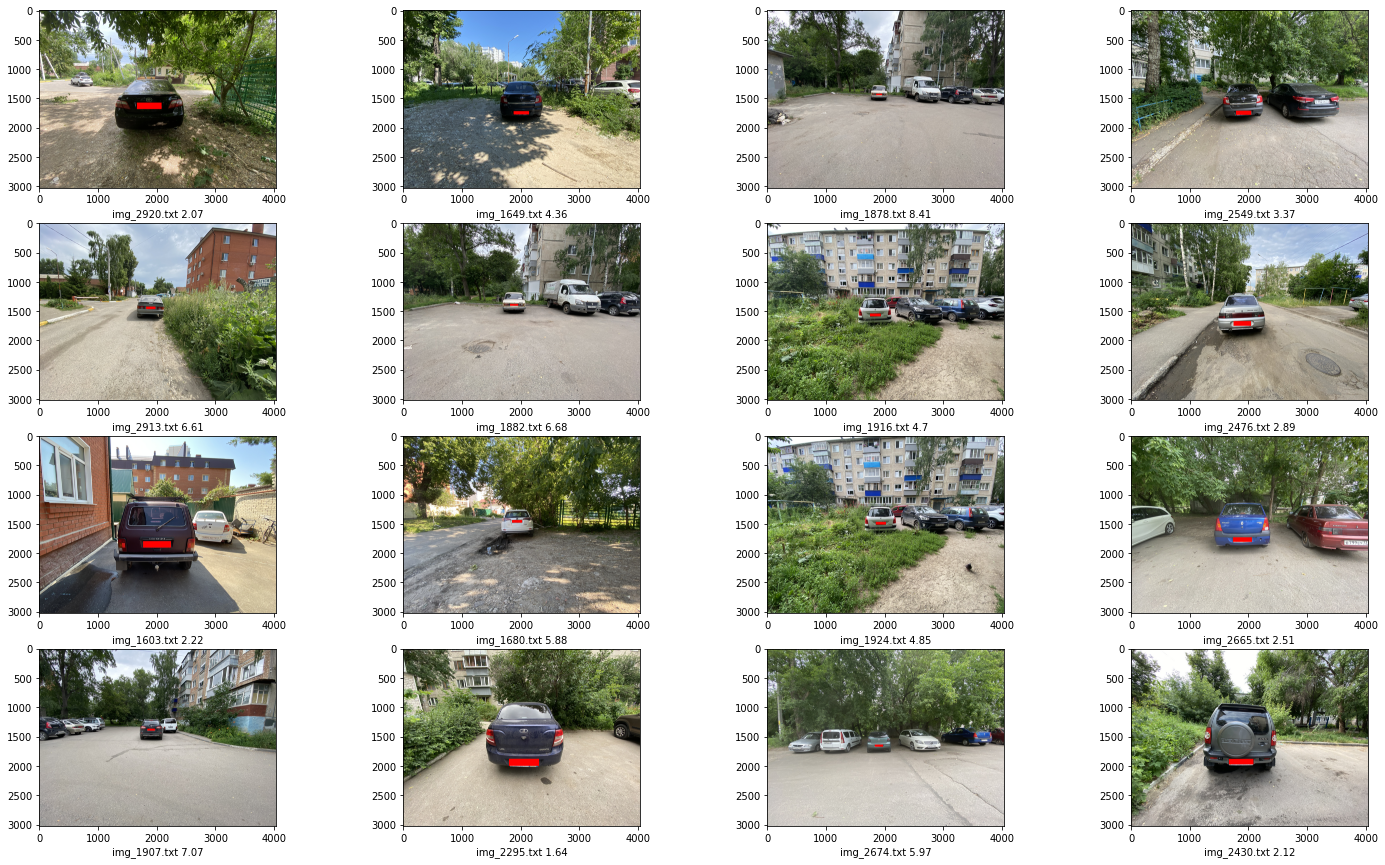

In [42]:
fig, axs = plt.subplots(4, 4, figsize=(25, 15)) #Создаем полотно из 14 графиков
x = 0
y = 0
i = 0

for val in labels[16 * idx:16 * idx + 16]: #Проходим по всем классам
  find_by_image = train_labels_df[train_labels_df['image_name'] == val.replace('.txt', '.jpg')]
  distance = find_by_image['distance'].values[0]
  
  axs[x][y].imshow(find_and_plot('/content/train', '/content/label', val)) #Отображение фотографии
  axs[x][y].set_xlabel(val + ' ' + str(distance))
  y += 1
  if i == 3 or i == 7 or i == 11:
    x += 1
    y = 0
  i += 1

In [153]:
test_img_names = set(os.listdir('/content/test'))
train_img_names = set(os.listdir('/content/train'))

In [154]:
test_img_names.intersection(train_img_names)

set()

In [155]:
train_labels_df = pd.read_csv('/content/train.csv', sep=';', index_col=None)

In [156]:
train_labels_df

image_name  distance
0    img_1596.jpg      4.88
1    img_1600.jpg      1.54
2    img_1601.jpg      3.68
3    img_1603.jpg      2.22
4    img_1605.jpg      3.73
..            ...       ...
525  img_2939.jpg      3.00
526  img_2940.jpg      3.46
527  img_2941.jpg      3.91
528  img_2944.jpg      5.20
529  img_2945.jpg      5.54

[530 rows x 2 columns]

In [157]:
train_labels_names = set(train_labels_df['image_name'].values)

In [158]:
train_labels_names.intersection(test_img_names)

set()

In [159]:
len(train_labels_names.intersection(train_img_names)) == len(train_img_names)

False

In [160]:
train_labels_df['image_name'].value_counts().head(40)

img_1596.jpg    1
img_2536.jpg    1
img_2570.jpg    1
img_2568.jpg    1
img_2563.jpg    1
img_2562.jpg    1
img_2561.jpg    1
img_2554.jpg    1
img_2553.jpg    1
img_2550.jpg    1
img_2549.jpg    1
img_2548.jpg    1
img_2547.jpg    1
img_2544.jpg    1
img_2539.jpg    1
img_2538.jpg    1
img_2535.jpg    1
img_2642.jpg    1
img_2533.jpg    1
img_2528.jpg    1
img_2527.jpg    1
img_2520.jpg    1
img_2519.jpg    1
img_2516.jpg    1
img_2514.jpg    1
img_2512.jpg    1
img_2511.jpg    1
img_2510.jpg    1
img_2507.jpg    1
img_2505.jpg    1
img_2504.jpg    1
img_2503.jpg    1
img_2574.jpg    1
img_2575.jpg    1
img_2577.jpg    1
img_2578.jpg    1
img_2638.jpg    1
img_2636.jpg    1
img_2635.jpg    1
img_2634.jpg    1
Name: image_name, dtype: int64

In [161]:
img_name = 'img_1596' + '.jpg'
train_labels_df[train_labels_df['image_name'] == img_name]

image_name  distance
0  img_1596.jpg      4.88

## Train / test

In [ ]:
!rm -rf label

In [ ]:
!unzip label.zip

Archive:  label.zip
   creating: label/
  inflating: label/img_1596.txt      
  inflating: label/img_1600.txt      
  inflating: label/img_1601.txt      
  inflating: label/img_1603.txt      
  inflating: label/img_1605.txt      
  inflating: label/img_1606.txt      
  inflating: label/img_1607.txt      
  inflating: label/img_1608.txt      
  inflating: label/img_1612.txt      
  inflating: label/img_1613.txt      
  inflating: label/img_1615.txt      
  inflating: label/img_1616.txt      
  inflating: label/img_1618.txt      
  inflating: label/img_1619.txt      
  inflating: label/img_1620.txt      
  inflating: label/img_1621.txt      
  inflating: label/img_1623.txt      
  inflating: label/img_1626.txt      
  inflating: label/img_1627.txt      
  inflating: label/img_1628.txt      
  inflating: label/img_1631.txt      
  inflating: label/img_1634.txt      
  inflating: label/img_1635.txt      
  inflating: label/img_1637.txt      
  inflating: label/img_1640.txt      
  inflatin

In [ ]:
# for heif_label in os.listdir('yolov5/runs/detect/yolo_licence_plate_det2/labels'):
#   shutil.copy('/content/yolov5/runs/detect/yolo_licence_plate_det2/labels/' + heif_label, '/content/label/' + heif_label)

Удаляем лейблы с неверными дистанциями

In [270]:
!rm '/content/label/img_1621.txt'
!rm '/content/label/img_1616.txt'
!rm '/content/label/img_1620.txt'

rm: cannot remove '/content/label/img_1621.txt': No such file or directory
rm: cannot remove '/content/label/img_1620.txt': No such file or directory


In [271]:
from re import I
train_data = []

for label in os.listdir('/content/label'):
  if '.txt' in label:
    best_label = find_best_label('/content/train', '/content/label', label)
    
    if '.heic' in label:
      img_name = label.replace('.heic.txt', '.heic')
    else:
      img_name = label.replace('.txt', '.jpg')
    results = [img_name] + [float(x) for x in best_label.split(' ')]
    train_data.append(results)


In [231]:
train_data

[['img_2608.jpg', 0.0, 0.477059, 0.545966, 0.113343, 0.032407, 4032.0, 3024.0],
 ['img_2411.jpg', 0.0, 0.492808, 0.54547, 0.159722, 0.041336, 4032.0, 3024.0],
 ['img_1677.jpg', 0.0, 0.485243, 0.49289, 0.060268, 0.018849, 4032.0, 3024.0],
 ['img_2905.jpg', 0.0, 0.473214, 0.507275, 0.053075, 0.017196, 4032.0, 3024.0],
 ['img_2600.jpg', 0.0, 0.478671, 0.553406, 0.039187, 0.012235, 4032.0, 3024.0],
 ['img_1676.jpg', 0.0, 0.504216, 0.47619, 0.107639, 0.031085, 4032.0, 3024.0],
 ['img_2783.jpg', 0.0, 0.486607, 0.497024, 0.040675, 0.011243, 4032.0, 3024.0],
 ['img_2690.jpg', 0.0, 0.474826, 0.489914, 0.031994, 0.008929, 4032.0, 3024.0],
 ['img_1964.jpg', 0.0, 0.449653, 0.511574, 0.049603, 0.01455, 4032.0, 3024.0],
 ['img_2345.jpg', 0.0, 0.489831, 0.506614, 0.079365, 0.023148, 4032.0, 3024.0],
 ['img_2774.jpg', 0.0, 0.473214, 0.532738, 0.050595, 0.015873, 4032.0, 3024.0],
 ['img_2492.jpg', 0.0, 0.469246, 0.518022, 0.034226, 0.011574, 4032.0, 3024.0],
 ['img_2643.jpg', 0.0, 0.478547, 0.488095, 0

In [272]:
train_data_df = pd.DataFrame(train_data, columns = ['image_name', 'cls', 'x_min', 'y_min', 'x_max', 'y_max', 'width', 'height'])

In [273]:
train_data_df

image_name  cls     x_min     y_min     x_max     y_max   width  height
0    img_2608.jpg  0.0  0.477059  0.545966  0.113343  0.032407  4032.0  3024.0
1    img_2411.jpg  0.0  0.492808  0.545470  0.159722  0.041336  4032.0  3024.0
2    img_1677.jpg  0.0  0.485243  0.492890  0.060268  0.018849  4032.0  3024.0
3    img_2905.jpg  0.0  0.473214  0.507275  0.053075  0.017196  4032.0  3024.0
4    img_2600.jpg  0.0  0.478671  0.553406  0.039187  0.012235  4032.0  3024.0
..            ...  ...       ...       ...       ...       ...     ...     ...
474  img_2270.jpg  0.0  0.475322  0.514550  0.052827  0.014550  4032.0  3024.0
475  img_1619.jpg  0.0  0.475694  0.557374  0.086806  0.025463  4032.0  3024.0
476  img_2016.jpg  0.0  0.490699  0.496528  0.036954  0.011574  4032.0  3024.0
477  img_2422.jpg  0.0  0.461930  0.516038  0.052827  0.017526  4032.0  3024.0
478  img_1647.jpg  0.0  0.511781  0.560185  0.082093  0.024471  4032.0  3024.0

[479 rows x 8 columns]

In [274]:
train_data_df = pd.merge(train_labels_df, train_data_df, how='left')

In [275]:
train_data_df

image_name  distance  cls     x_min     y_min     x_max     y_max  \
0    img_1596.jpg      4.88  0.0  0.491567  0.529431  0.050595  0.015212   
1    img_1600.jpg      1.54  0.0  0.517237  0.854993  0.174355  0.050595   
2    img_1601.jpg      3.68  0.0  0.498884  0.557044  0.070188  0.020172   
3    img_1603.jpg      2.22  0.0  0.497892  0.614253  0.116815  0.036045   
4    img_1605.jpg      3.73  0.0  0.507440  0.526951  0.070437  0.018849   
..            ...       ...  ...       ...       ...       ...       ...   
525  img_2939.jpg      3.00  0.0  0.485119  0.581019  0.070933  0.025132   
526  img_2940.jpg      3.46  0.0  0.490451  0.541501  0.061260  0.018188   
527  img_2941.jpg      3.91  0.0  0.468874  0.574735  0.054812  0.015873   
528  img_2944.jpg      5.20  0.0  0.456349  0.544478  0.041667  0.011574   
529  img_2945.jpg      5.54  0.0  0.468626  0.563161  0.038442  0.010582   

      width  height  
0    4032.0  3024.0  
1    4032.0  3024.0  
2    4032.0  3024.0  
3    4032.0  3024.0  
4    4032.0  3024.0  
..      ...     ...  
525  4032.0  3024.0  
526  4032.0  3024.0  
527  4032.0  3024.0  
528  4032.0  3024.0  
529  4032.0  3024.0  

[530 rows x 9 columns]

In [276]:
train_data_df.drop(train_data_df[train_data_df['x_min'].isna()].index, inplace=True)

In [277]:
train_data_df

image_name  distance  cls     x_min     y_min     x_max     y_max  \
0    img_1596.jpg      4.88  0.0  0.491567  0.529431  0.050595  0.015212   
1    img_1600.jpg      1.54  0.0  0.517237  0.854993  0.174355  0.050595   
2    img_1601.jpg      3.68  0.0  0.498884  0.557044  0.070188  0.020172   
3    img_1603.jpg      2.22  0.0  0.497892  0.614253  0.116815  0.036045   
4    img_1605.jpg      3.73  0.0  0.507440  0.526951  0.070437  0.018849   
..            ...       ...  ...       ...       ...       ...       ...   
525  img_2939.jpg      3.00  0.0  0.485119  0.581019  0.070933  0.025132   
526  img_2940.jpg      3.46  0.0  0.490451  0.541501  0.061260  0.018188   
527  img_2941.jpg      3.91  0.0  0.468874  0.574735  0.054812  0.015873   
528  img_2944.jpg      5.20  0.0  0.456349  0.544478  0.041667  0.011574   
529  img_2945.jpg      5.54  0.0  0.468626  0.563161  0.038442  0.010582   

      width  height  
0    4032.0  3024.0  
1    4032.0  3024.0  
2    4032.0  3024.0  
3    4032.0  3024.0  
4    4032.0  3024.0  
..      ...     ...  
525  4032.0  3024.0  
526  4032.0  3024.0  
527  4032.0  3024.0  
528  4032.0  3024.0  
529  4032.0  3024.0  

[479 rows x 9 columns]

In [280]:
train_data_df = train_data_df.sort_values('distance')

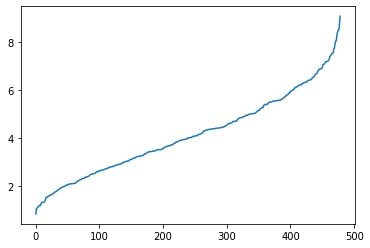

In [281]:
plt.plot(range(479), train_data_df['distance'])
plt.show()

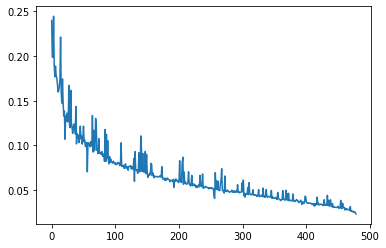

In [283]:
plt.plot(range(479), train_data_df['x_max'])
plt.show()

In [269]:
train_data_df[100:130]

image_name  distance  cls     x_min     y_min     x_max     y_max  \
484  img_2863.jpg      2.65  0.0  0.460689  0.523313  0.080605  0.022156   
263  img_2342.jpg      2.65  0.0  0.476190  0.563657  0.078373  0.025463   
279  img_2385.jpg      2.66  0.0  0.509301  0.552414  0.079117  0.023479   
173  img_1945.jpg      2.66  0.0  0.486235  0.538856  0.079613  0.022817   
296  img_2429.jpg      2.67  0.0  0.480531  0.580522  0.079613  0.022817   
291  img_2420.jpg      2.67  0.0  0.466022  0.558366  0.080853  0.023479   
132  img_1857.jpg      2.68  0.0  0.473958  0.558532  0.080357  0.025132   
168  img_1932.jpg      2.69  0.0  0.504216  0.580192  0.077381  0.023479   
241  img_2300.jpg      2.70  0.0  0.474082  0.518353  0.078125  0.022817   
24   img_1640.jpg      2.72  0.0  0.484003  0.487269  0.102927  0.028108   
383  img_2620.jpg      2.72  0.0  0.498016  0.516865  0.076389  0.026455   
498  img_2891.jpg      2.73  0.0  0.471602  0.486938  0.077629  0.023479   
112  img_1818.jpg      2.74  0.0  0.485739  0.544808  0.077629  0.022156   
245  img_2305.jpg      2.74  0.0  0.479787  0.509259  0.076637  0.029101   
221  img_2266.jpg      2.77  0.0  0.487227  0.526124  0.074157  0.021825   
326  img_2485.jpg      2.78  0.0  0.480779  0.532738  0.077629  0.023810   
355  img_2550.jpg      2.78  0.0  0.470982  0.639881  0.079365  0.032407   
385  img_2623.jpg      2.80  0.0  0.480407  0.542163  0.074405  0.025463   
370  img_2584.jpg      2.80  0.0  0.464782  0.501984  0.074405  0.022487   
396  img_2639.jpg      2.81  0.0  0.461930  0.519180  0.072173  0.023810   
286  img_2408.jpg      2.81  0.0  0.467634  0.503803  0.076141  0.022817   
504  img_2899.jpg      2.82  0.0  0.472098  0.476852  0.076141  0.024471   
146  img_1887.jpg      2.84  0.0  0.492932  0.541667  0.076637  0.020503   
316  img_2462.jpg      2.84  0.0  0.472594  0.511409  0.076637  0.022817   
201  img_2003.jpg      2.85  0.0  0.446429  0.538360  0.077381  0.020503   
469  img_2788.jpg      2.86  0.0  0.465898  0.489418  0.073661  0.021825   
11   img_1616.jpg      2.86  0.0  0.481895  0.587798  0.169147  0.047950   
308  img_2451.jpg      2.87  0.0  0.447793  0.552579  0.076141  0.023810   
320  img_2470.jpg      2.87  0.0  0.482515  0.575066  0.075645  0.028439   
322  img_2476.jpg      2.89  0.0  0.469370  0.569610  0.073165  0.026124   

      width  height  
484  4032.0  3024.0  
263  4032.0  3024.0  
279  4032.0  3024.0  
173  4032.0  3024.0  
296  4032.0  3024.0  
291  4032.0  3024.0  
132  4032.0  3024.0  
168  4032.0  3024.0  
241  4032.0  3024.0  
24   4032.0  3024.0  
383  4032.0  3024.0  
498  4032.0  3024.0  
112  4032.0  3024.0  
245  4032.0  3024.0  
221  4032.0  3024.0  
326  4032.0  3024.0  
355  4032.0  3024.0  
385  4032.0  3024.0  
370  4032.0  3024.0  
396  4032.0  3024.0  
286  4032.0  3024.0  
504  4032.0  3024.0  
146  4032.0  3024.0  
316  4032.0  3024.0  
201  4032.0  3024.0  
469  4032.0  3024.0  
11   4032.0  3024.0  
308  4032.0  3024.0  
320  4032.0  3024.0  
322  4032.0  3024.0

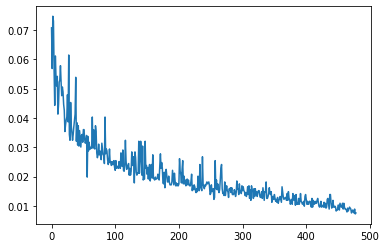

In [284]:
plt.plot(range(479), train_data_df['y_max'])
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (16,8)

In [175]:
index = 4

In [261]:
img_name = train_data_df['image_name'][index]

NameError: ignored

In [177]:
img_name

'img_1605.jpg'

In [178]:
img = Image.open(os.path.join('/content/train/', img_name))

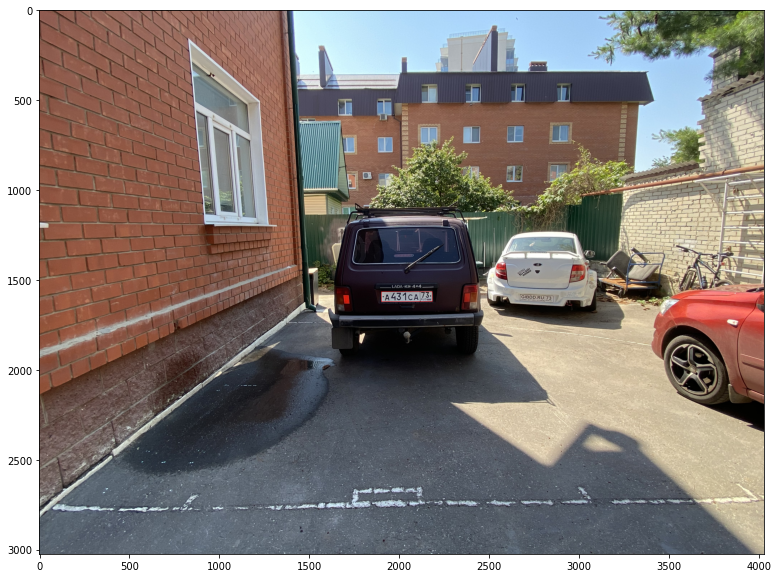

In [179]:
plot_bounding_box(img, train_data_df['x_min'][index], train_data_df['y_min'][index], train_data_df['x_max'][index], train_data_df['y_max'][index])


In [180]:
index = 145

In [181]:
img_name = train_data_df['image_name'][index]

In [182]:
img_name

'img_1886.jpg'

In [183]:
img = Image.open(os.path.join('/content/train/', img_name))

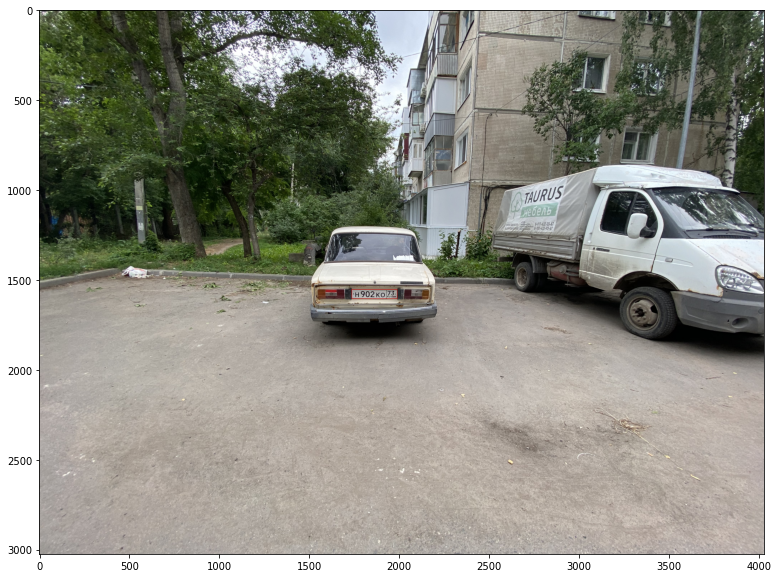

In [184]:
plot_bounding_box(img, train_data_df['x_min'][index], train_data_df['y_min'][index], train_data_df['x_max'][index], train_data_df['y_max'][index])


In [248]:
from catboost import CatBoostRegressor

In [249]:
from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D,GlobalMaxPooling1D, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # Слои для сети

from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую

import time # Импортируем библиотеку time

In [187]:
train_data_df

image_name  distance  cls     x_min     y_min     x_max     y_max  \
0    img_1596.jpg      4.88  0.0  0.491567  0.529431  0.050595  0.015212   
1    img_1600.jpg      1.54  0.0  0.517237  0.854993  0.174355  0.050595   
2    img_1601.jpg      3.68  0.0  0.498884  0.557044  0.070188  0.020172   
3    img_1603.jpg      2.22  0.0  0.497892  0.614253  0.116815  0.036045   
4    img_1605.jpg      3.73  0.0  0.507440  0.526951  0.070437  0.018849   
..            ...       ...  ...       ...       ...       ...       ...   
525  img_2939.jpg      3.00  0.0  0.485119  0.581019  0.070933  0.025132   
526  img_2940.jpg      3.46  0.0  0.490451  0.541501  0.061260  0.018188   
527  img_2941.jpg      3.91  0.0  0.468874  0.574735  0.054812  0.015873   
528  img_2944.jpg      5.20  0.0  0.456349  0.544478  0.041667  0.011574   
529  img_2945.jpg      5.54  0.0  0.468626  0.563161  0.038442  0.010582   

      width  height  
0    4032.0  3024.0  
1    4032.0  3024.0  
2    4032.0  3024.0  
3    4032.0  3024.0  
4    4032.0  3024.0  
..      ...     ...  
525  4032.0  3024.0  
526  4032.0  3024.0  
527  4032.0  3024.0  
528  4032.0  3024.0  
529  4032.0  3024.0  

[480 rows x 9 columns]

In [285]:
xTrain, xVal, yTrain, yVal = train_test_split(train_data_df[['x_max']], train_data_df[['distance']].values, test_size=0.2, random_state=45)
print(xTrain.shape) #посмотрим на форму текстов из обучающей выборки
print(yTrain.shape) #и на форму соответсвующих им классов

(383, 1)
(383, 1)


In [287]:
#Создаём полносвязную сеть
model01 = Sequential()
#Входной полносвязный слой
model01.add(Dense(500, input_dim=1, activation="relu"))
#Слой регуляризации Dropout
#Третий полносвязный слой
# model01.add(Dense(100, activation='relu'))
model01.add(Dropout(0.2))
model01.add(Dense(100, activation='relu'))
#Слой регуляризации Dropout
#model01.add(Dropout(0.2))
#Выходной полносвязный слой
model01.add(Dense(1, activation='relu'))


model01.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='mse', 
              metrics=['mean_squared_error'])

#Обучаем сеть на выборке
history = model01.fit(xTrain, 
                    yTrain, 
                    epochs=100,
                    batch_size=16,
                    validation_data=(xVal, yVal))

Epoch 1/100
24/24 [==============================] - 1s 8ms/step - loss: 19.6425 - mean_squared_error: 19.6425 - val_loss: 19.0722 - val_mean_squared_error: 19.0722
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 19.1354 - mean_squared_error: 19.1354 - val_loss: 18.4709 - val_mean_squared_error: 18.4709
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 18.4293 - mean_squared_error: 18.4293 - val_loss: 17.6253 - val_mean_squared_error: 17.6253
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 17.4285 - mean_squared_error: 17.4285 - val_loss: 16.4584 - val_mean_squared_error: 16.4584
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 16.1035 - mean_squared_error: 16.1035 - val_loss: 14.9619 - val_mean_squared_error: 14.9619
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 14.5137 - mean_squared_error: 14.5137 - val_loss: 13.1798 - val_mean_squared_error: 13.1798
Epoch 7/10

In [290]:
history = model01.fit(xTrain, 
                    yTrain, 
                    epochs=500,
                    batch_size=16,
                    validation_data=(xVal, yVal))

Epoch 1/500
24/24 [==============================] - 0s 5ms/step - loss: 0.1424 - mean_squared_error: 0.1424 - val_loss: 0.1136 - val_mean_squared_error: 0.1136
Epoch 2/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1441 - mean_squared_error: 0.1441 - val_loss: 0.1211 - val_mean_squared_error: 0.1211
Epoch 3/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1491 - mean_squared_error: 0.1491 - val_loss: 0.1120 - val_mean_squared_error: 0.1120
Epoch 4/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1289 - mean_squared_error: 0.1289 - val_loss: 0.1124 - val_mean_squared_error: 0.1124
Epoch 5/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1378 - mean_squared_error: 0.1378 - val_loss: 0.1152 - val_mean_squared_error: 0.1152
Epoch 6/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1331 - mean_squared_error: 0.1331 - val_loss: 0.1128 - val_mean_squared_error: 0.1128
Epoch 7/500
24/24 [===============

In [401]:
from tensorflow.keras.utils import plot_model

In [404]:
model01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               1500      
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               50100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 51,701
Trainable params: 51,701
Non-trainable params: 0
_________________________________________________________________


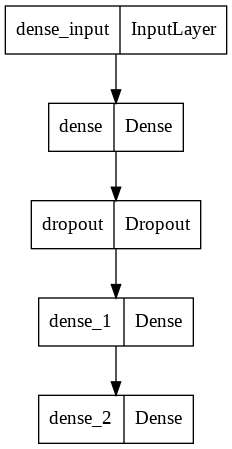

In [402]:
plot_model(model01)

In [291]:
from keras import backend as K
# Change learning rate to 0.001 and train for 50 more epochs
K.set_value(model01.optimizer.learning_rate, 0.00001)
print("Learning rate before second fit:", model01.optimizer.learning_rate.numpy())

Learning rate before second fit: 1e-05


In [292]:
history = model01.fit(xTrain, 
                    yTrain, 
                    epochs=500,
                    batch_size=16,
                    validation_data=(xVal, yVal))

Epoch 1/500
24/24 [==============================] - 0s 5ms/step - loss: 0.1234 - mean_squared_error: 0.1234 - val_loss: 0.1114 - val_mean_squared_error: 0.1114
Epoch 2/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1318 - mean_squared_error: 0.1318 - val_loss: 0.1112 - val_mean_squared_error: 0.1112
Epoch 3/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1292 - mean_squared_error: 0.1292 - val_loss: 0.1112 - val_mean_squared_error: 0.1112
Epoch 4/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1166 - mean_squared_error: 0.1166 - val_loss: 0.1112 - val_mean_squared_error: 0.1112
Epoch 5/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1183 - mean_squared_error: 0.1183 - val_loss: 0.1112 - val_mean_squared_error: 0.1112
Epoch 6/500
24/24 [==============================] - 0s 4ms/step - loss: 0.1268 - mean_squared_error: 0.1268 - val_loss: 0.1113 - val_mean_squared_error: 0.1113
Epoch 7/500
24/24 [===============

In [201]:
model01.save_weights('/content/drive/MyDrive/AI/hacks-ai/ulyanovsk/weight2.h5')

In [202]:
model01.save('/content/drive/MyDrive/AI/hacks-ai/ulyanovsk/model2.h5')

In [293]:
# Импортируем модель
from sklearn.ensemble import RandomForestRegressor

In [294]:
# Создаем и выбираем модель
model_rf = RandomForestRegressor(n_estimators = 300)

In [295]:
# Обучаем
model_rf.fit(xTrain, yTrain)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(n_estimators=300)

In [243]:
# Действующая классификация
pred_rf = model_rf.predict(xVal)


In [ ]:
rf_probs = model_rf.predict_proba(x_test)

In [296]:
print('Model RandomForestClassifier Accuracy:', model_rf.score(xVal, yVal))

Model RandomForestClassifier Accuracy: 0.9378280446275135


In [297]:

from sklearn.tree import DecisionTreeRegressor

# Создаём и обучаем дерево принятия решений
tree = DecisionTreeRegressor()
tree.fit(xTrain, yTrain)

DecisionTreeRegressor()

In [298]:
print('Model DecisionTree Accuracy:', tree.score(xVal, yVal))


Model DecisionTree Accuracy: 0.9105953985483982


In [250]:
model_2 = CatBoostRegressor(depth=8, iterations=10000)

# Fit model
model_2.fit(xTrain, yTrain)

Выходные данные были обрезаны до нескольких последних строк (5000).
5000:	learn: 0.2552085	total: 6.97s	remaining: 6.97s
5001:	learn: 0.2552036	total: 6.98s	remaining: 6.97s
5002:	learn: 0.2551972	total: 6.98s	remaining: 6.97s
5003:	learn: 0.2551732	total: 6.98s	remaining: 6.97s
5004:	learn: 0.2551603	total: 6.98s	remaining: 6.96s
5005:	learn: 0.2551502	total: 6.98s	remaining: 6.96s
5006:	learn: 0.2551232	total: 6.98s	remaining: 6.96s
5007:	learn: 0.2550966	total: 6.98s	remaining: 6.96s
5008:	learn: 0.2550845	total: 6.99s	remaining: 6.96s
5009:	learn: 0.2550736	total: 6.99s	remaining: 6.96s
5010:	learn: 0.2550560	total: 6.99s	remaining: 6.96s
5011:	learn: 0.2550434	total: 6.99s	remaining: 6.96s
5012:	learn: 0.2550350	total: 6.99s	remaining: 6.95s
5013:	learn: 0.2550050	total: 6.99s	remaining: 6.95s
5014:	learn: 0.2549839	total: 6.99s	remaining: 6.95s
5015:	learn: 0.2549744	total: 6.99s	remaining: 6.95s
5016:	learn: 0.2549676	total: 7s	remaining: 6.95s
5017:	learn: 0.2549649	total: 7s	r

In [251]:
catboost_pred = model_2.predict(xVal)

In [253]:
from sklearn.metrics import mean_squared_error, mean_absolute_error 

In [299]:
deep_pred = model01.predict(xVal)

In [254]:
mean_absolute_error(yVal, pred_rf)

0.259962191241435

In [255]:
mean_squared_error(yVal, pred_rf)

0.17127220799480966

In [300]:
mean_absolute_error(yVal, deep_pred)

0.21273213341832156

In [301]:
mean_squared_error(yVal, deep_pred)

0.11095935359428404

In [256]:
mean_absolute_error(yVal, catboost_pred)

0.25776799072906137

In [257]:
mean_squared_error(yVal, catboost_pred)

0.17479102671937094

In [220]:
pred_rf

array([3.4129    , 3.44623333, 2.77843333, 4.73816667, 6.2602    ,
       6.82415556, 3.09396667, 2.7993    , 7.52483333, 4.76456667,
       3.88806667, 5.53186667, 3.08      , 4.06316667, 4.36445056,
       2.83194444, 3.6377    , 3.53487333, 6.41119444, 4.93848333,
       3.32076667, 3.94406667, 4.08746667, 2.8668    , 5.05739167,
       2.83603333, 4.41076111, 2.79466667, 3.0544    , 3.9501    ,
       7.22716667, 1.65056667, 2.7859    , 3.26286667, 8.44026667,
       6.03505111, 2.86541111, 2.65727259, 6.41751944, 3.9895    ,
       2.11283333, 6.82436667, 4.80916667, 3.5239    , 3.5227    ,
       4.7371    , 3.26536667, 6.94146667, 4.51598333, 3.94823333,
       2.0687    , 4.43246667, 1.83303333, 3.0904    , 6.64818333,
       4.54947778, 5.15321222, 2.70356667, 4.48446667, 5.05355468,
       6.08785   , 5.94231444, 2.37556667, 2.87526667, 3.35856667,
       3.90306667, 5.60879278, 3.0898    , 6.73450444, 7.21823333,
       8.26636667, 3.90306667, 2.75083333, 4.08746667, 2.22123

In [221]:
deep_pred

array([[3.543096 ],
       [3.4976966],
       [2.4181378],
       [4.758384 ],
       [6.3061037],
       [6.8111887],
       [3.235563 ],
       [2.6631727],
       [7.554034 ],
       [4.664118 ],
       [3.8311214],
       [5.493475 ],
       [3.210941 ],
       [4.045691 ],
       [4.4189043],
       [2.8805165],
       [3.2874398],
       [3.6669128],
       [6.528775 ],
       [4.7130666],
       [3.24391  ],
       [4.026822 ],
       [4.3032155],
       [3.0207677],
       [5.119932 ],
       [2.458351 ],
       [4.5297546],
       [2.8094285],
       [3.1757195],
       [4.1118436],
       [7.189375 ],
       [1.6615382],
       [2.9335306],
       [3.435894 ],
       [8.06498  ],
       [6.003882 ],
       [2.8419874],
       [2.8076074],
       [6.5332   ],
       [3.7817957],
       [2.2417839],
       [6.853995 ],
       [4.759891 ],
       [3.1606486],
       [3.4864233],
       [4.7727065],
       [3.4347594],
       [6.905735 ],
       [3.800686 ],
       [4.0234923],


In [222]:
catboost_pred

array([3.41534431, 3.43135603, 2.6527473 , 4.74858999, 6.30511986,
       6.75228462, 3.13920623, 3.12327909, 7.43132182, 4.63257756,
       3.93235344, 5.50506802, 3.10597774, 4.09537954, 4.45720063,
       2.85013595, 3.56478317, 3.6028571 , 6.43623096, 4.78138535,
       3.25463782, 3.92795669, 4.1079153 , 2.84806662, 5.13917721,
       2.86157237, 4.47191131, 2.76389126, 3.031318  , 3.96119941,
       7.21763387, 1.55142336, 2.87080435, 3.30061316, 8.38464898,
       6.02659456, 2.78394502, 2.75471337, 6.48264341, 3.91503676,
       2.17894417, 6.80703869, 4.76186358, 3.46252806, 3.41096047,
       4.86636616, 3.29423961, 6.89037219, 4.42152025, 4.04552791,
       2.15147087, 4.45600965, 1.83184705, 3.13309385, 6.60684202,
       4.50607769, 5.21241949, 2.62166983, 4.51413286, 5.0692039 ,
       6.16628967, 6.08008467, 2.48327588, 2.80218945, 3.34970237,
       4.07718369, 5.84930098, 2.90923586, 6.76101179, 7.18417942,
       8.28042224, 4.07718369, 2.78989943, 4.12346316, 2.21962

## TEST predict

In [371]:
!python /content/yolov5/detect.py --source /content/tmp/ --save-txt --weights /content/drive/MyDrive/AI/hacks-ai/ulyanovsk/best2.pt --conf 0.30 --name yolo_licence_plate_det

detect: weights=['/content/drive/MyDrive/AI/hacks-ai/ulyanovsk/best2.pt'], source=/content/tmp/, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=yolo_licence_plate_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.2-56-g30e674b Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5l summary: 367 layers, 46108278 parameters, 0 gradients, 107.6 GFLOPs
image 1/1 /content/tmp/img_1629.jpg: 480x640 (no detections), 18.0ms
Speed: 0.5ms pre-process, 18.0ms inference, 0.4ms NMS per image at shape (1, 3, 640, 640)
Results saved to yolov5/runs/detect/yolo_licence_plate_det7
0 labels saved to yolov5/runs/detect/yolo_licence_plate_det7/labels


In [71]:
!python /content/yolov5/detect.py --img 480 --source /content/test/ --save-txt --save-conf --weights /content/drive/MyDrive/AI/hacks-ai/ulyanovsk/best.pt --conf 0.30 --name yolo_licence_plate_det

detect: weights=['/content/drive/MyDrive/AI/hacks-ai/ulyanovsk/best.pt'], source=/content/test/, data=yolov5/data/coco128.yaml, imgsz=[480, 480], conf_thres=0.3, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=yolo_licence_plate_det, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.2-57-gf2b8f3f Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
image 1/521 /content/test/img_1597.jpg: 384x480 2 garbages, 12.6ms
image 2/521 /content/test/img_1598.jpg: 384x480 2 garbages, 8.9ms
image 3/521 /content/test/img_1599.jpg: 384x480 2 garbages, 9.3ms
image 4/521 /content/test/img_1602.jpg: 384x480 2 garbages, 9.5ms
image 5/521 /content/test/img_1604

In [194]:
detect_path = '/content/yolov5/runs/detect/yolo_licence_plate_det3'

In [195]:
len(os.listdir(detect_path + '/labels'))

520

In [168]:
find_best_label_test(detect_path, detect_path + '/labels', 'img_1905.txt', 4032, 3024)

131.49964799999998
149.998464
79.00018560000001


'0 0.462798 0.479497 0.0257937 0.00859788 0.801208 4032 3024'

In [198]:
best_label = find_best_label(detect_path, detect_path + '/labels', 'img_2028.txt')

In [199]:
best_label

'0 0.461186 0.548611 0.0354663 0.0112434 0.854991 4032 3024'

In [200]:
cls, x1, y1, w1, h1, _, img_w, img_h = best_label.split(' ')

In [158]:
img_h

'4032'

In [201]:
img = Image.open(os.path.join('/content/test', 'img_2028.jpg'))

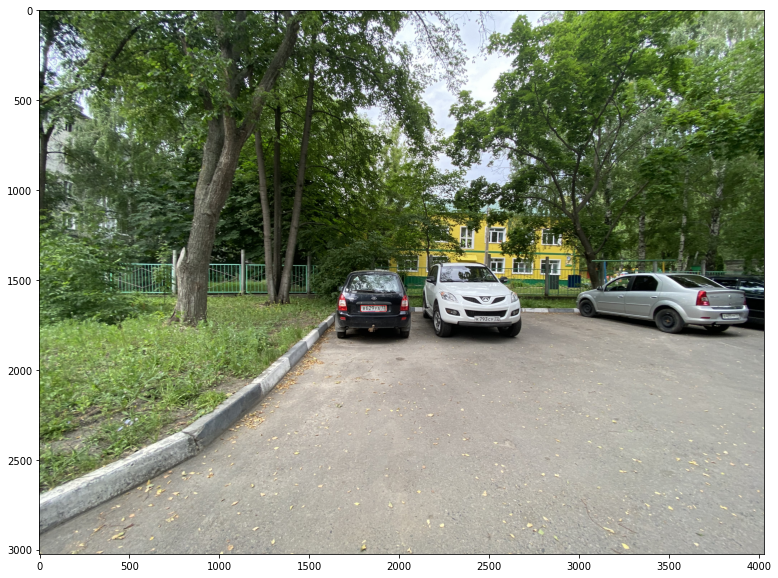

In [202]:
plot_bounding_box(img, float(x1), float(y1), float(w1), float(h1))


In [203]:
detect_path = '/content/yolov5/runs/detect/yolo_licence_plate_det3'

In [204]:
test_data = []

for label in os.listdir(detect_path + '/labels'):
  best_label = find_best_label(detect_path, detect_path + '/labels', label)
  img_name = label.replace('.txt', '') if 'heic' in label else label.replace('.txt', '.jpg')
  results = [img_name] + [float(x) for x in best_label.split(' ')]
  test_data.append(results)


In [205]:
test_data

[['img_1693.jpg',
  0.0,
  0.474826,
  0.598214,
  0.0612599,
  0.0191799,
  0.941692,
  4032.0,
  3024.0],
 ['img_2619.jpg',
  0.0,
  0.46999,
  0.529927,
  0.062004,
  0.0188492,
  0.903839,
  4032.0,
  3024.0],
 ['img_2006.jpg',
  0.0,
  0.427083,
  0.49041,
  0.0505952,
  0.015873,
  0.939998,
  4032.0,
  3024.0],
 ['img_2652.jpg',
  0.0,
  0.471478,
  0.505787,
  0.0570436,
  0.0181878,
  0.914389,
  4032.0,
  3024.0],
 ['img_2325.jpg',
  0.0,
  0.443328,
  0.489418,
  0.0493552,
  0.0165344,
  0.840688,
  4032.0,
  3024.0],
 ['img_2785.jpg',
  0.0,
  0.464286,
  0.511574,
  0.0530754,
  0.015873,
  0.927826,
  4032.0,
  3024.0],
 ['img_2754.jpg',
  0.0,
  0.496156,
  0.552579,
  0.103919,
  0.0337302,
  0.933155,
  4032.0,
  3024.0],
 ['img_2370.jpg',
  0.0,
  0.481399,
  0.565311,
  0.0689484,
  0.0214947,
  0.919162,
  4032.0,
  3024.0],
 ['img_2663.jpg',
  0.0,
  0.489087,
  0.524306,
  0.0535714,
  0.0175265,
  0.897681,
  4032.0,
  3024.0],
 ['img_1904.jpg',
  0.0,
  0.47544

In [ ]:
# test_data = []

# for img_name in tqdm(test_img_names): 
#   if 'heic' in img_name:
#     heif_file = pyheif.read(os.path.join('/content/test/', img_name))
#     img = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw", heif_file.mode, heif_file.stride)
#   else:
#     img = Image.open(os.path.join('/content/test/', img_name))
#   results = model(np.array(img))
#   if results.xyxy[0].shape != torch.Size([0, 6]):
#     results = [img_name] + results.xyxy[0][0].numpy().tolist()
#     test_data.append(results)

  0%|          | 0/521 [00:00<?, ?it/s]

In [208]:
from tensorflow import keras

In [209]:
model01 = keras.models.load_model('/content/drive/MyDrive/AI/hacks-ai/ulyanovsk/model2.h5')

In [206]:
test_data_df = pd.DataFrame(test_data, columns = ['image_name', 'cls', 'x_min', 'y_min', 'x_max', 'y_max', 'cfg', 'width', 'height'])

In [302]:
preds = model01.predict(test_data_df[['x_max', 'y_max']])

In [ ]:
catboost_preds = model_2.predict(test_data_df[['x_max', 'y_max']])

In [303]:
preds

array([[3.6058216],
       [3.5646033],
       [4.279942 ],
       [3.8393805],
       [4.3834424],
       [4.09246  ],
       [2.172289 ],
       [3.1799228],
       [4.0549664],
       [4.8162155],
       [6.4215465],
       [8.073745 ],
       [6.592455 ],
       [5.321559 ],
       [3.6058216],
       [1.9253818],
       [3.7844238],
       [5.635907 ],
       [5.496195 ],
       [2.4797704],
       [2.6074336],
       [6.0200906],
       [6.3645787],
       [1.4879564],
       [4.968958 ],
       [7.3331   ],
       [6.0200906],
       [4.485275 ],
       [2.2138977],
       [6.089952 ],
       [2.9927673],
       [8.016776 ],
       [2.600715 ],
       [6.877323 ],
       [7.5609994],
       [2.5805564],
       [5.2517104],
       [3.6882536],
       [4.51073  ],
       [3.1661854],
       [4.5361853],
       [6.0200906],
       [3.0974913],
       [4.6380167],
       [3.7569482],
       [3.8805933],
       [6.0200906],
       [0.9799143],
       [3.9987192],
       [3.4272199],


In [ ]:
preds = model_2.predict(test_data_df[['x_min', 'y_min', 'x_max', 'y_max', 'width', 'height']])

In [304]:
test_data_df['distance'] = preds

In [305]:
sample_solution_df = test_data_df[['image_name', 'distance']]

In [306]:
test_img_names = set(os.listdir('/content/test'))

In [307]:
lost_test_items = []

for file_name in test_img_names - set(sample_solution_df['image_name'].values):
  if '.heic.jpg' not in file_name:
    lost_test_items.append([file_name, 3.0])

In [308]:
lost_test_items

[['img_2674.heic', 3.0]]

In [310]:
sample_solution_df[sample_solution_df['image_name']=='img_2677.heic']

image_name  distance
83  img_2677.heic  5.461271

In [311]:
lost_test_items_df = pd.DataFrame(lost_test_items, columns=['image_name', 'distance'])

In [312]:
sample_solution_df = pd.concat([sample_solution_df, lost_test_items_df])

In [313]:
sample_solution_df.to_csv('sample_solution.csv', sep=';', index=False)

In [85]:
labels = os.listdir(detect_path + '/labels')

In [227]:
idx = 3 # 0 10

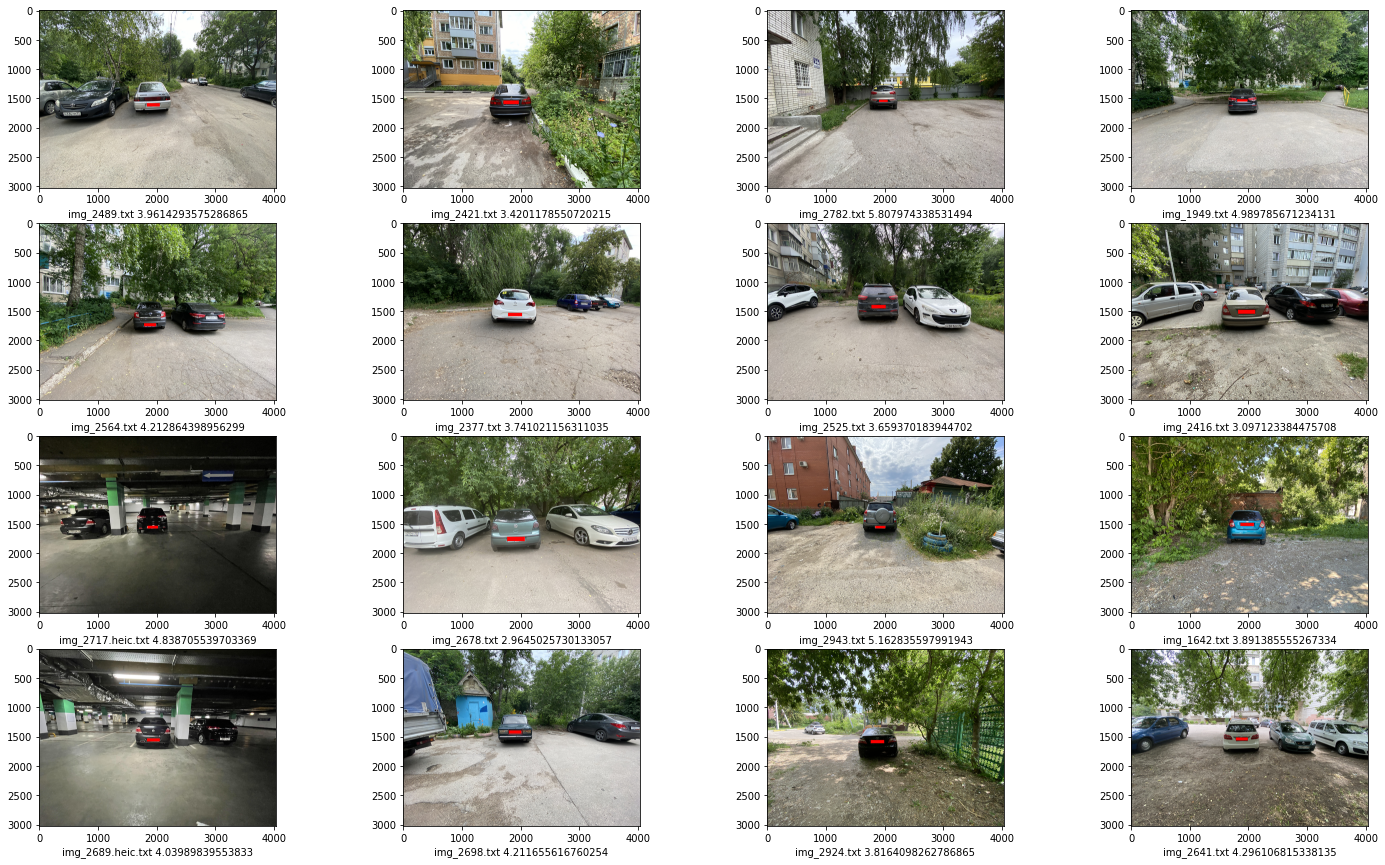

In [228]:
fig, axs = plt.subplots(4, 4, figsize=(25, 15)) #Создаем полотно из 14 графиков
x = 0
y = 0
i = 0

for val in labels[16 * idx:16 * idx + 16]: #Проходим по всем классам
  img_name = val.replace('.txt', '') if '.heic' in val else val.replace('.txt', '.jpg')
  find_by_image = sample_solution_df[sample_solution_df['image_name'] == img_name]
  distance = find_by_image['distance'].values[0]
  
  axs[x][y].imshow(find_and_plot('/content/test', detect_path + '/labels', val)) #Отображение фотографии
  axs[x][y].set_xlabel(val + ' ' + str(distance))
  y += 1
  if i == 3 or i == 7 or i == 11:
    x += 1
    y = 0
  i += 1